## Dataset Preprocessing

### Importing Setup and Dependencies

In [1]:
# Install necessary libraries (uncomment and run this cell once if not already installed)
# !pip install nltk textblob textstat spellchecker
# !python -m textblob.download_corpora

In [2]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker       # For detecting and correcting spelling errors
from textblob import TextBlob               # Simplifies text processing tasks such as sentiment analysis
import textstat
import string
import re
from functools import lru_cache

# Download necessary NLTK resources
nltk.download('punkt')                      # Used for word and sentence tokenization
nltk.download('stopwords')                  # Stopwords list (Commonly filtered out words (e.g., ‘the’, ‘is’, ‘at’) for more efficient text processing.)
nltk.download('wordnet')                    # Facilitates the lemmatization process, reducing words to their base forms
nltk.download('averaged_perceptron_tagger') # Used for part-of-speech (POS) tagging.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/harshtiwari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harshtiwari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/harshtiwari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/harshtiwari/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Loading Dataset and basic Exploration

In [3]:
# Load the dataset
df = pd.read_csv('LC_loans_granting_model_dataset.csv')

/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/684895832.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('LC_loans_granting_model_dataset.csv')


In [4]:
# Prinitng first few rows of the dataset
df.head()

,id,issue_d,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,zip_code,Default,title,desc
0,68407277,Dec-2015,55000.0,5.91,3600,677.0,1,10+ years,debt_consolidation,MORTGAGE,PA,190xx,0,Debt consolidation,NaN
1,68355089,Dec-2015,65000.0,16.06,24700,717.0,1,10+ years,small_business,MORTGAGE,SD,577xx,0,Business,NaN
2,68341763,Dec-2015,71000.0,13.85,20000,697.0,1,10+ years,home_improvement,MORTGAGE,IL,605xx,0,NaN,NaN
3,68476807,Dec-2015,104433.0,25.37,10400,697.0,1,3 years,major_purchase,MORTGAGE,PA,174xx,0,Major purchase,NaN
4,68426831,Dec-2015,34000.0,10.20,11950,692.0,1,4 years,debt_consolidation,RENT,GA,300xx,0,Debt consolidation,NaN


In [5]:
# Filtering dataset to retain rows with non-empty loan descriptions
loan_df = df[df['desc'].notna()]

In [6]:
# Prinitng first few rows of the dataset
loan_df.head()

,id,issue_d,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,zip_code,Default,title,desc
1296,361774,Dec-2015,115000.0,5.10,6400,677.0,1,3 years,debt_consolidation,MORTGAGE,MO,631xx,0,Debt consolidation,We knew that using our credit cards to finance...
29168,67025,Dec-2015,65000.0,17.17,10000,752.0,1,10+ years,credit_card,MORTGAGE,CT,064xx,0,Credit card refinancing,"I had a bad year two years ago, with some late..."
33329,391742,Dec-2015,100000.0,18.13,10000,707.0,1,4 years,debt_consolidation,RENT,IL,770xx,0,Debt consolidation,"Lenders, I have the ability to pay off my curr..."
44444,56705,Nov-2015,33500.0,18.38,11000,702.0,1,10+ years,debt_consolidation,MORTGAGE,MO,658xx,0,Debt consolidation,"I paid off my first Prosper loan, but had an e..."
59975,365090,Nov-2015,60000.0,26.58,6000,662.0,1,7 years,debt_consolidation,RENT,NY,112xx,0,Debt consolidation,I want to cut down on my credit card debt now ...


In [7]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119099 entries, 1296 to 1250099
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                119099 non-null  int64  
 1   issue_d           119099 non-null  object 
 2   revenue           119099 non-null  float64
 3   dti_n             119099 non-null  float64
 4   loan_amnt         119099 non-null  int64  
 5   fico_n            119099 non-null  float64
 6   experience_c      119099 non-null  int64  
 7   emp_length        119099 non-null  object 
 8   purpose           119099 non-null  object 
 9   home_ownership_n  119099 non-null  object 
 10  addr_state        119099 non-null  object 
 11  zip_code          119099 non-null  object 
 12  Default           119099 non-null  int64  
 13  title             119090 non-null  object 
 14  desc              119099 non-null  object 
dtypes: float64(3), int64(4), object(8)
memory usage: 14.5+ MB


**Dataset Description**
Loan identification variables:

id: Loan id (unique identifier). 

issue_d: Month and year in which the loan was approved.

Quantitative variables:

revenue: Borrower's self-declared annual income during registration. 

dti_n: Indebtedness ratio for obligations excluding mortgage. Monthly information. This ratio has been calculated considering the indebtedness of the whole group of applicants. It is estimated as the ratio calculated using the co-borrowers’ total payments on the total debt obligations divided by the co-borrowers’ combined monthly income.

loan_amnt: Amount of credit requested by the borrower. 

fico_n: Defined between 300 and 850, reported by Fair Isaac Corporation as a risk measure based on historical credit information reported at the time of application. This value has been calculated as the average of the variables “fico_range_low” and “fico_range_high” in the original dataset.

experience_c: Binary variable that indicates whether the borrower is new to the entity. This variable is constructed from the credit date of the previous obligation in LC and the credit date of the current obligation; if the difference between dates is positive, it is not considered as a new experience with LC.

Categorical variables:

emp_length: Categorical variable with the employment length of the borrower (includes the no information category) 

purpose:  Credit purpose category for the loan request. 

home_ownership_n: Homeownership status provided by the borrower in the registration process. Categories defined by LC: “mortgage”, “rent”, “own”, “other”, “any”, “none”.  We merged the categories “other”, “any” and “none” as “other”.

addr_state: Borrower's residence state from the USA. 

zip_code: Zip code of the borrower's residence.

Textual variables

title: Title of the credit request description provided by the borrower.

desc: Description of the credit request provided by the borrower.

In [8]:
# Checking for missing values in each column of the filtered dataset
loan_df.isnull().sum()

id                  0
issue_d             0
revenue             0
dti_n               0
loan_amnt           0
fico_n              0
experience_c        0
emp_length          0
purpose             0
home_ownership_n    0
addr_state          0
zip_code            0
Default             0
title               9
desc                0
dtype: int64

In [9]:
# Fill missing values in the 'title' column with mode
loan_df['title'].dropna(inplace=True)
print(loan_df.isnull().sum())

id                  0
issue_d             0
revenue             0
dti_n               0
loan_amnt           0
fico_n              0
experience_c        0
emp_length          0
purpose             0
home_ownership_n    0
addr_state          0
zip_code            0
Default             0
title               9
desc                0
dtype: int64


/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/379692552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df['title'].dropna(inplace=True)


### Visualizing outlier in numerical variables

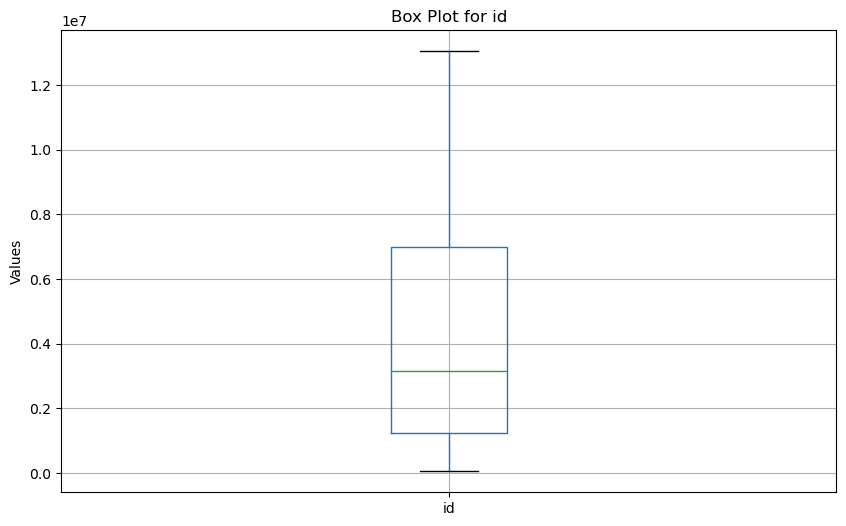

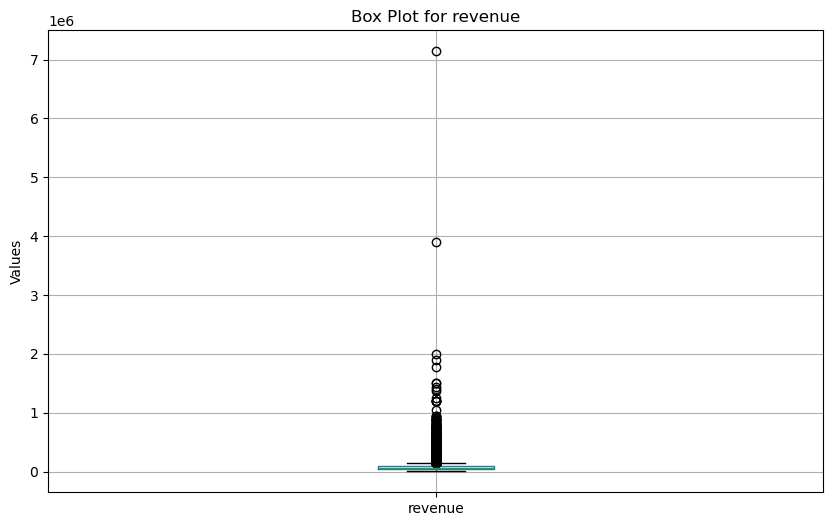

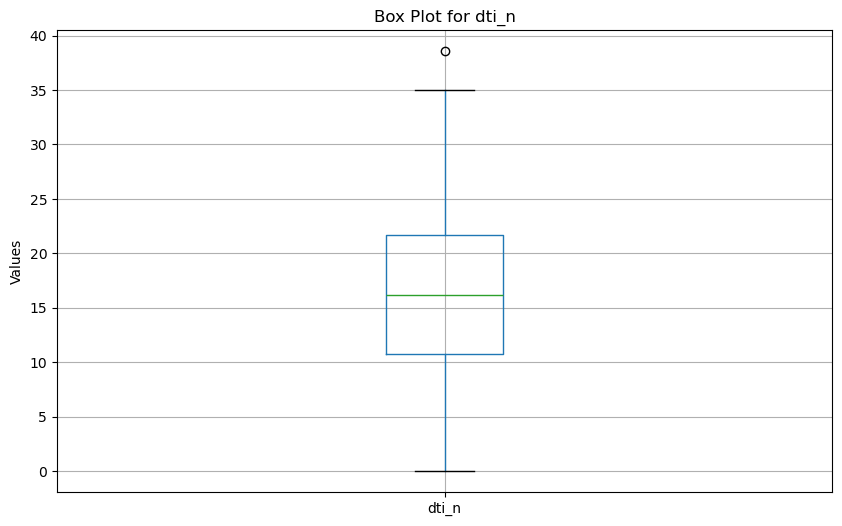

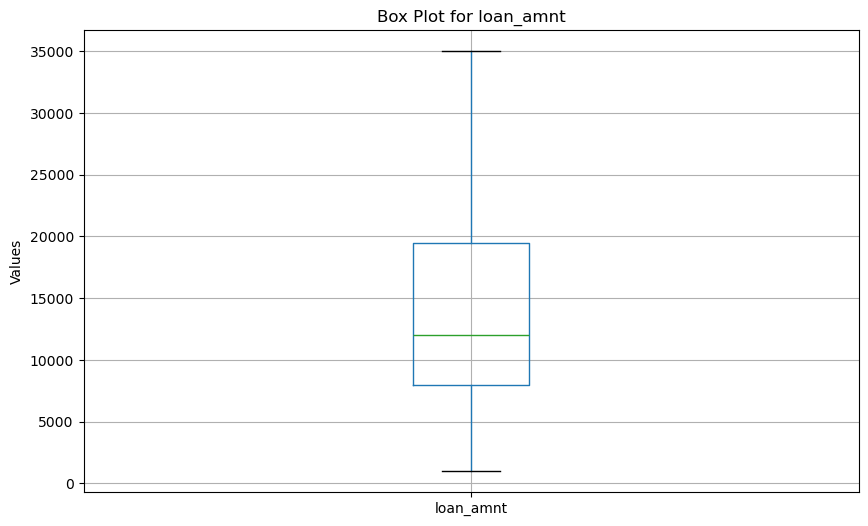

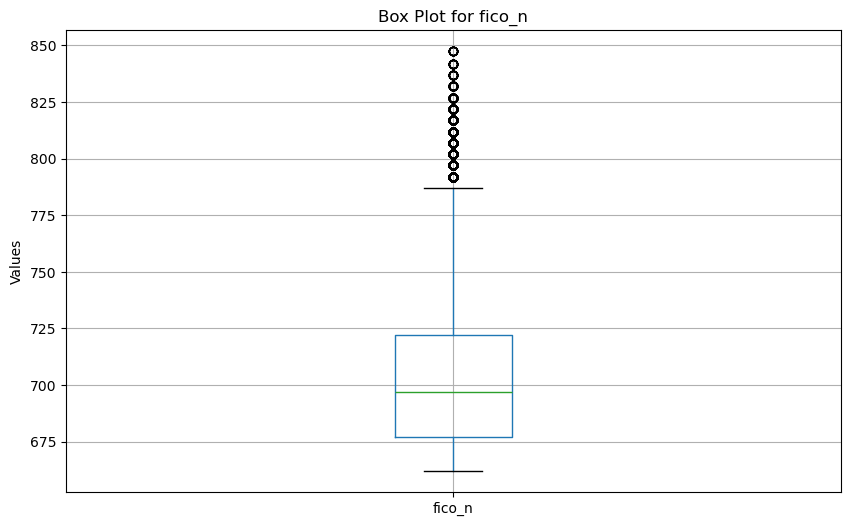

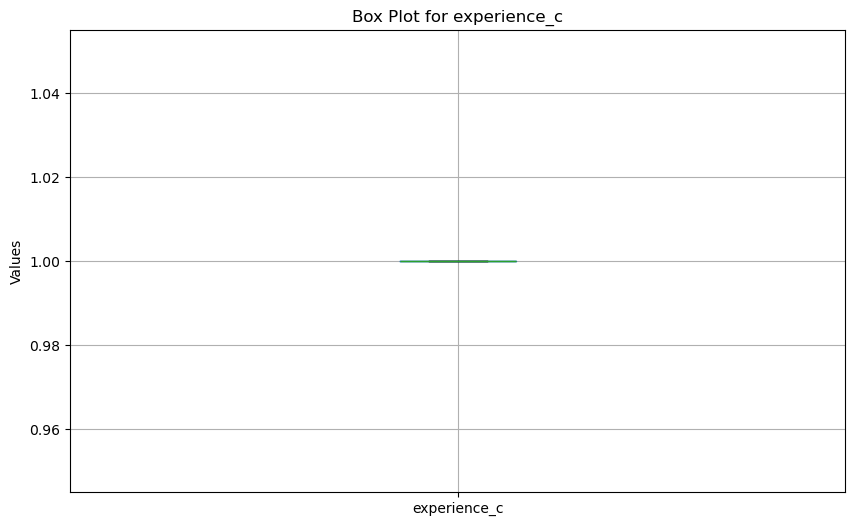

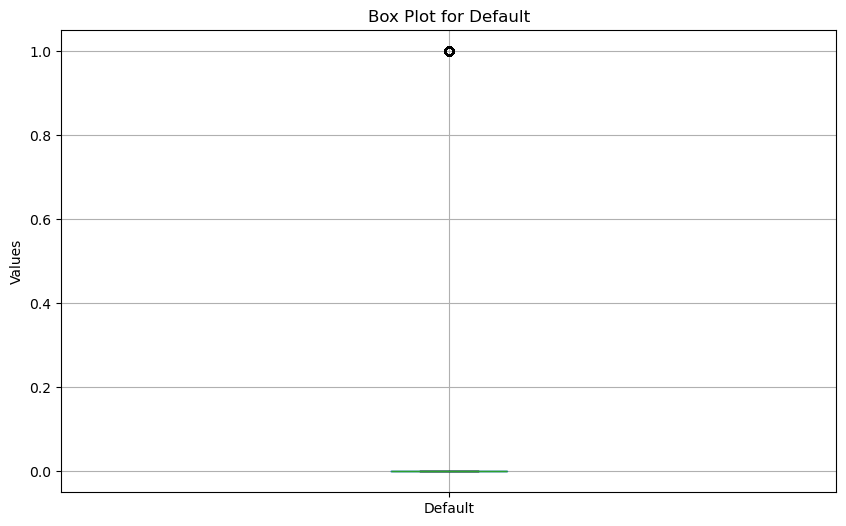

In [10]:
# Selecting numeric columns (int64 and float64) for visualization
numeric_columns = loan_df.select_dtypes(include=['float64', 'int64']).columns

# Generating individual boxplots to visualize distributions and detect outliers for each numeric column
for column in numeric_columns:
    plt.figure(figsize=(10, 6)) 
    loan_df.boxplot(column)  # Creating the boxplot for the current numeric column
    plt.title(f'Box Plot for {column}')  # Adding a title to identify the plot
    plt.ylabel('Values')  # Labeling the y-axis
    plt.show()  # Displaying the plot

In [11]:
def print_outliers(loan_df):
    # This function identifies and prints outliers in numeric columns
    for column in loan_df.select_dtypes(include=['number']).columns:
        Q1 = loan_df[column].quantile(0.25)          # First quartile
        Q3 = loan_df[column].quantile(0.75)          # Third quartile
        IQR = Q3 - Q1                                # Interquartile range
        lower_bound = Q1 - 1.5 * IQR                 # Lower bound for outlier detection
        upper_bound = Q3 + 1.5 * IQR                 # Upper bound for outlier detection
        
        # Identify outliers outside the IQR range
        outliers = loan_df[(loan_df[column] < lower_bound) | (loan_df[column] > upper_bound)]
        
        # Print column name and outliers if found
        if not outliers.empty:
            print(f"Outliers in {column}:")
            print(outliers[column])
            print("\n")
        else:
            print(f"No outliers in {column}.")

# Call the function
print_outliers(loan_df)

No outliers in id.
Outliers in revenue:
273553     155000.0
585904     180000.0
851435     200000.0
851451     160000.0
851527     273500.0
             ...   
1193163    195000.0
1193248    160000.0
1193303    230000.0
1193307    260000.0
1193409    203492.0
Name: revenue, Length: 4897, dtype: float64


Outliers in dti_n:
470021    38.57
Name: dti_n, dtype: float64


No outliers in loan_amnt.
Outliers in fico_n:
851312     807.0
851330     792.0
851486     792.0
851549     797.0
852049     792.0
           ...  
1192797    827.0
1193047    807.0
1193313    792.0
1193338    792.0
1193416    812.0
Name: fico_n, Length: 2530, dtype: float64


No outliers in experience_c.
Outliers in Default:
316055     1
321474     1
473816     1
662399     1
760010     1
          ..
1193461    1
1193471    1
1193479    1
1193481    1
1193483    1
Name: Default, Length: 18190, dtype: int64




- Outliers were retained as they reflect real-world variations in financial data, such as high income or credit scores, which are meaningful for modeling. Removing them could result in loss of valuable information and introduce bias, especially in the case of the target variable Default.

#### Feature Engineering: Region, FICO Category, and Financial Ratios

In [12]:
#convert issued_d to datetime
loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'], errors='coerce')

/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/1119977150.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'], errors='coerce')
/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/1119977150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df['issue_d'] = pd.to_datetime(loan_df['issue_d'], errors='coerce')


In [13]:
# Map US state abbreviations to regions
def state_to_region(state):
    region_map = {
        'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
        'Midwest':   ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI'],
        'South':     ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV',
                      'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
        'West':      ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
    }
    for region, states in region_map.items():
        if state in states:
            return region
    return 'Other'  # Catch-all for unknown/missing states

# Convert FICO score to credit category
def fico_category(fico_score):
    if pd.isnull(fico_score):
        return "Unknown"
    elif fico_score < 580:
        return "Poor"
    elif fico_score < 670:
        return "Fair"
    elif fico_score < 740:
        return "Good"
    elif fico_score <= 800:
        return "Very Good"
    else:
        return "Excellent"

# Create new features based on business logic
loan_df['loan_utilization'] = loan_df['loan_amnt'] / loan_df['revenue']           # Loan-to-income ratio
loan_df['region'] = loan_df['addr_state'].apply(state_to_region)                  # Regional grouping
loan_df['fico_category'] = loan_df['fico_n'].apply(fico_category)                 # Credit quality label
loan_df['debt_load_index'] = loan_df['loan_amnt'] * loan_df['dti_n']              # Approx. debt burden

/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/2973093985.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df['loan_utilization'] = loan_df['loan_amnt'] / loan_df['revenue']           # Loan-to-income ratio
/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/2973093985.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df['region'] = loan_df['addr_state'].apply(state_to_region)                  # Regional grouping
/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/

In [14]:
loan_df.head()

,id,issue_d,revenue,dti_n,loan_amnt,fico_n,experience_c,emp_length,purpose,home_ownership_n,addr_state,zip_code,Default,title,desc,loan_utilization,region,fico_category,debt_load_index
1296,361774,2015-12-01,115000.0,5.10,6400,677.0,1,3 years,debt_consolidation,MORTGAGE,MO,631xx,0,Debt consolidation,We knew that using our credit cards to finance...,0.055652,Midwest,Good,32640.0
29168,67025,2015-12-01,65000.0,17.17,10000,752.0,1,10+ years,credit_card,MORTGAGE,CT,064xx,0,Credit card refinancing,"I had a bad year two years ago, with some late...",0.153846,Northeast,Very Good,171700.0
33329,391742,2015-12-01,100000.0,18.13,10000,707.0,1,4 years,debt_consolidation,RENT,IL,770xx,0,Debt consolidation,"Lenders, I have the ability to pay off my curr...",0.100000,Midwest,Good,181300.0
44444,56705,2015-11-01,33500.0,18.38,11000,702.0,1,10+ years,debt_consolidation,MORTGAGE,MO,658xx,0,Debt consolidation,"I paid off my first Prosper loan, but had an e...",0.328358,Midwest,Good,202180.0
59975,365090,2015-11-01,60000.0,26.58,6000,662.0,1,7 years,debt_consolidation,RENT,NY,112xx,0,Debt consolidation,I want to cut down on my credit card debt now ...,0.100000,Northeast,Fair,159480.0


In [15]:
print("Summary Statistics for Numerical Features:")
print(loan_df.describe())
print("\n")

Summary Statistics for Numerical Features:
                 id                        issue_d       revenue  \
count  1.190990e+05                         119099  1.190990e+05   
mean   4.342149e+06  2012-09-27 15:48:10.271118848  7.244781e+04   
min    5.473400e+04            2008-04-01 00:00:00  4.000000e+03   
25%    1.242677e+06            2012-05-01 00:00:00  4.500000e+04   
50%    3.149399e+06            2013-01-01 00:00:00  6.200000e+04   
75%    6.995916e+06            2013-09-01 00:00:00  8.700000e+04   
max    1.304815e+07            2016-08-01 00:00:00  7.141778e+06   
std    3.764672e+06                            NaN  5.308719e+04   

               dti_n      loan_amnt         fico_n  experience_c  \
count  119099.000000  119099.000000  119099.000000      119099.0   
mean       16.379206   13999.739083     703.535109           1.0   
min         0.000000    1000.000000     662.000000           1.0   
25%        10.780000    8000.000000     677.000000           1.0   
50% 

### Visual Exploration

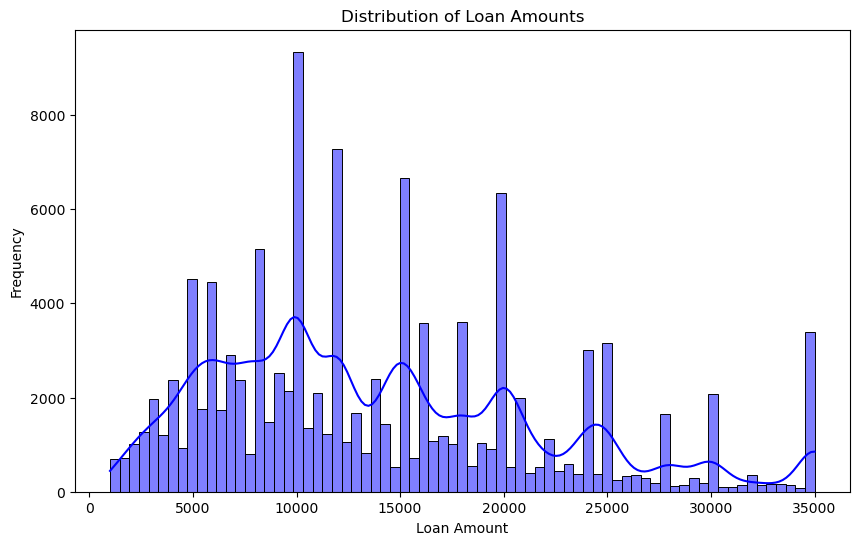

In [16]:
plt.figure(figsize=(10, 6))

# Plot histogram and KDE of loan amounts
sns.histplot(loan_df['loan_amnt'], kde=True, color='blue')

# Add labels and title
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

The loan amount distribution is multi-modal with clear spikes at common round values like $10,000, $15,000, $20,000, and $35,000 — suggesting standardized loan offerings.
The right tail shows fewer large loans, but no extreme outliers. The KDE (blue curve) confirms this skewed but structured distribution, indicating the platform favors certain standard loan sizes over others.

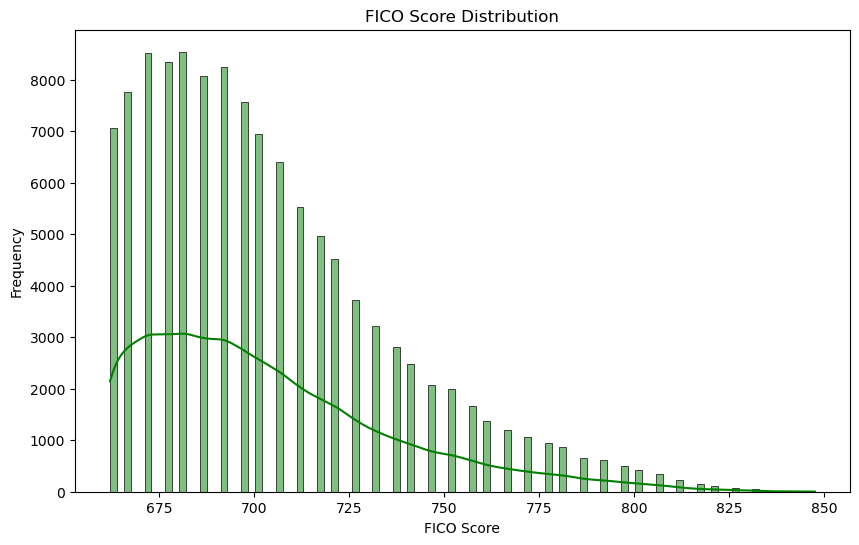

In [17]:
plt.figure(figsize=(10, 6))

# Plot histogram and KDE of FICO scores
sns.histplot(loan_df['fico_n'], kde=True, color='green')

# Add labels and title
plt.title('FICO Score Distribution')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()

The FICO score distribution is right-skewed, with the majority of applicants falling in the 670–710 range, which corresponds to “Fair” to “Good” credit categories.
There is a gradual decline in frequency as scores increase beyond 720, with very few applicants having “Excellent” scores above 800. This trend is typical for lending platforms, where most borrowers have mid-tier credit profiles.

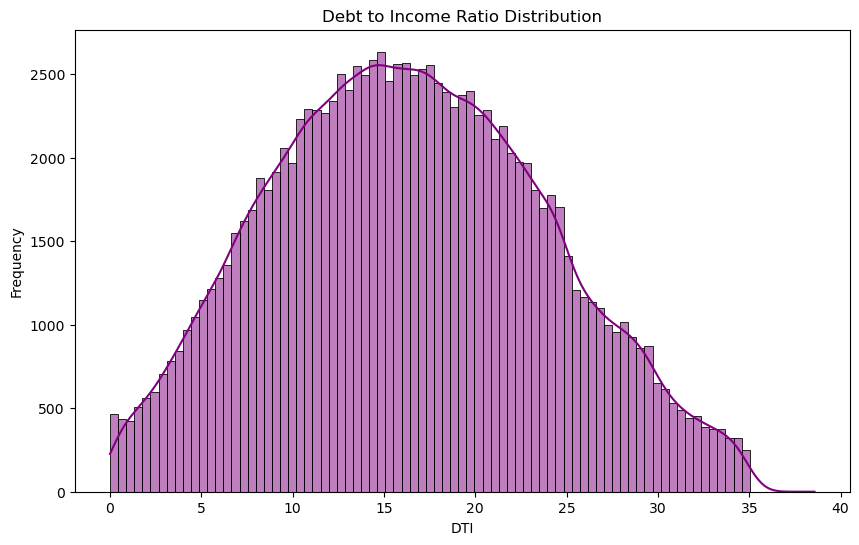

In [18]:
plt.figure(figsize=(10, 6))

# Plot histogram and KDE for DTI values
sns.histplot(loan_df['dti_n'], kde=True, color='purple')

# Add plot title and axis labels
plt.title('Debt to Income Ratio Distribution')
plt.xlabel('DTI')
plt.ylabel('Frequency')
plt.show()

The Debt-to-Income (DTI) ratio shows a near-normal distribution, slightly right-skewed, with a peak around 15–20%, which is typical for personal loan applicants.
Most borrowers maintain moderate debt levels relative to their income, and very few exceed 35%, which is often considered a risk threshold by lenders. This healthy distribution supports a relatively low-risk lending portfolio.

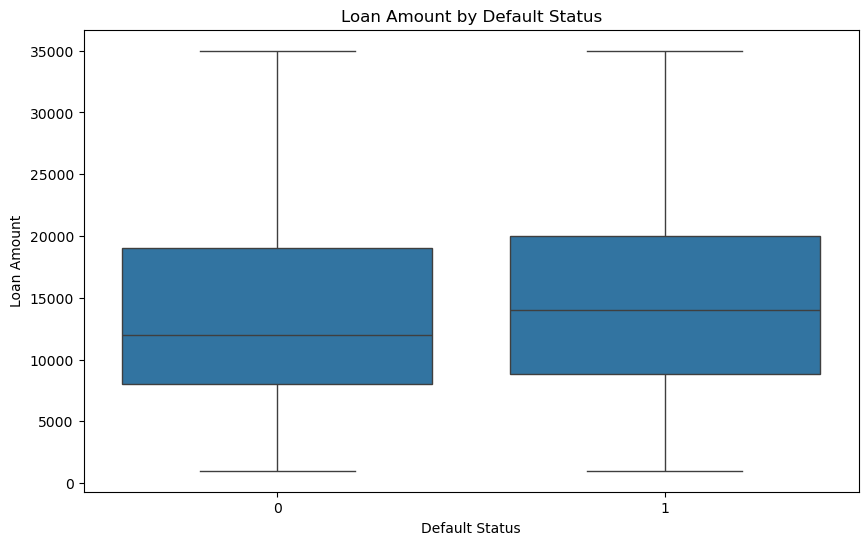

In [19]:
plt.figure(figsize=(10, 6))

# Boxplot of loan amounts grouped by default status
sns.boxplot(x='Default', y='loan_amnt', data=loan_df)

# Add title and axis labels
plt.title('Loan Amount by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Loan Amount')
plt.show()

Borrowers who defaulted (Default = 1) tend to have slightly higher median loan amounts than those who didn’t default (Default = 0).
Both groups show a wide range of loan sizes, but the upper quartile and whiskers for defaulters are slightly elevated, indicating a possible association between higher loan size and increased risk of default. However, the overlap suggests loan amount alone may not be a strong predictor of default and should be evaluated in combination with other features.

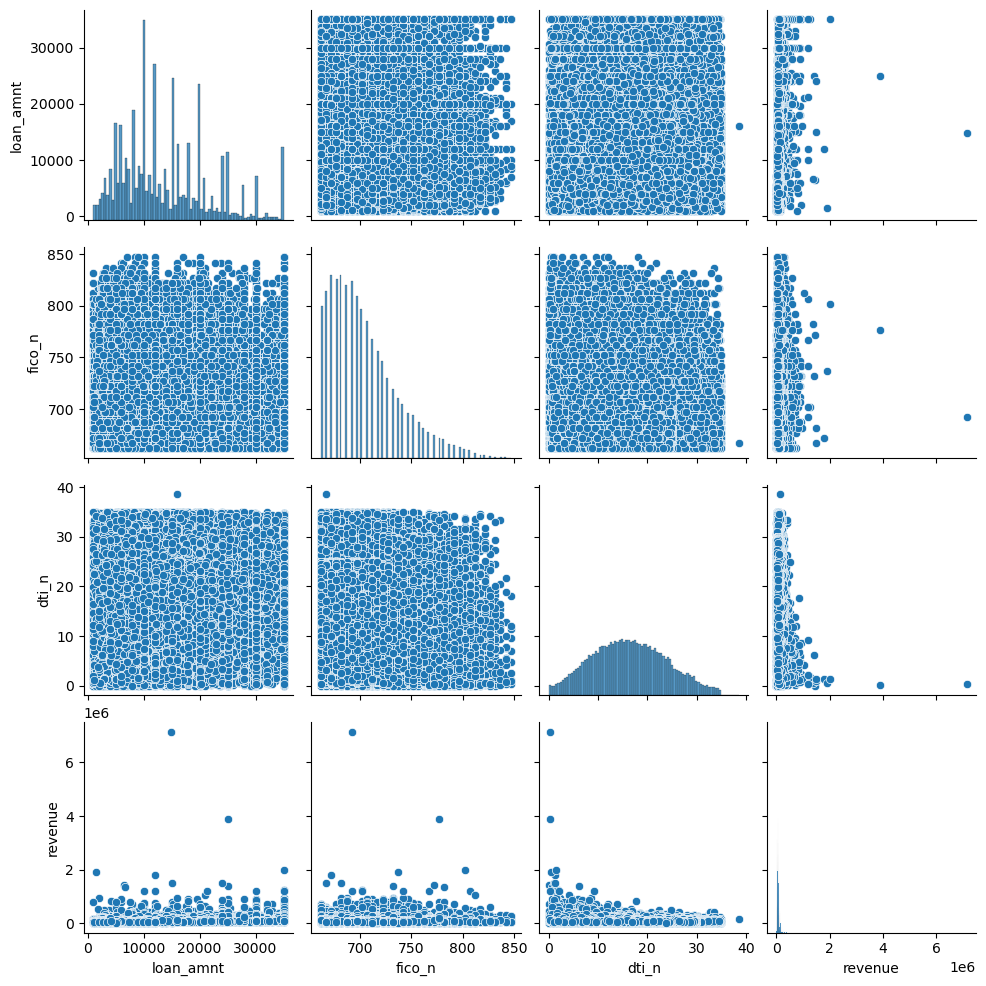

In [20]:
# Select key numeric features for pairwise visualization
select_columns = ['loan_amnt', 'fico_n', 'dti_n', 'revenue']

# Generate pairplot (scatter + histograms + KDEs)
sns.pairplot(loan_df[select_columns])
plt.show()

The pairplot reveals a few key insights:
- Revenue vs DTI/Loan Amount: A clear inverse pattern emerges — as revenue increases, both DTI and loan amount generally decrease, suggesting that high-income individuals tend to borrow proportionally less.
- FICO Score Correlations: There’s no strong visual relationship between FICO score and loan amount or DTI, although we observe that FICO scores are skewed toward the higher end.
- Loan Amount and DTI: These appear somewhat independent, with no clear linear correlation, possibly due to the effect of revenue acting as a third variable.
- Outliers: A few extreme revenue values are visible, reinforcing earlier outlier detection — though we opted to retain them.

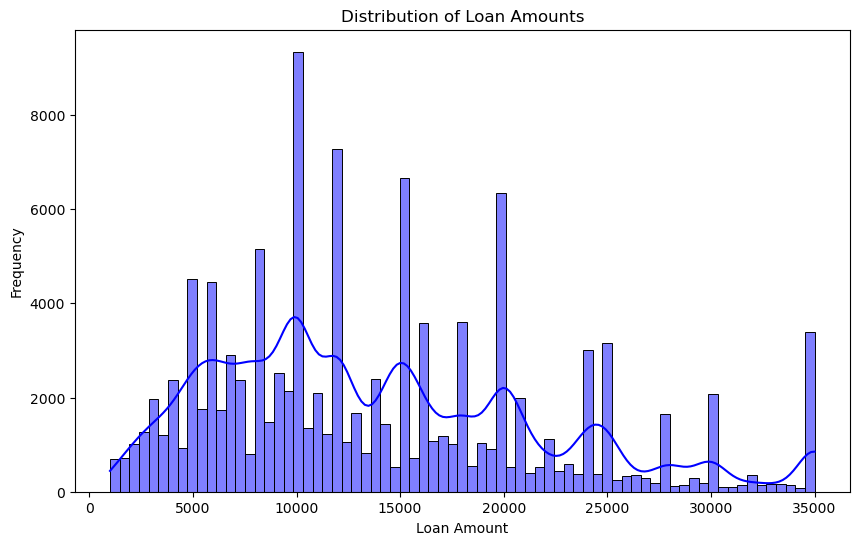

In [21]:
plt.figure(figsize=(10, 6))

# Histogram with KDE to visualize loan amount distribution
sns.histplot(loan_df['loan_amnt'], kde=True, color='blue')

plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()

The plot shows that loan amounts are clustered around round numbers, with peaks at $10,000, $15,000, $20,000, and $35,000, likely reflecting standardized loan packages. The distribution is right-skewed, and the KDE curve confirms multiple local modes. The pattern suggests that while borrowers vary in loan size, most opt for commonly offered loan brackets.

#### Exploring Textual Columns

In [22]:
# Display all unique values in the 'title' column
loan_df['title'].unique().tolist()

# Count and display the frequency of each unique title
unique_titles = loan_df['title'].value_counts()
unique_titles.to_dict()

{'Debt consolidation': 17457,
 'Debt Consolidation': 7586,
 'Credit card refinancing': 6820,
 'Consolidation': 2276,
 'debt consolidation': 2177,
 'Debt Consolidation Loan': 1819,
 'Home improvement': 1533,
 'Other': 1286,
 'Credit Card Consolidation': 1141,
 'consolidation': 972,
 'Personal Loan': 956,
 'Consolidation Loan': 907,
 'Home Improvement': 855,
 'Credit Card Refinance': 660,
 'Credit Card Payoff': 632,
 'Consolidate': 591,
 'Business': 552,
 'Personal': 539,
 'Major purchase': 445,
 'Loan': 420,
 'personal': 356,
 'Debt': 351,
 'consolidate': 336,
 'Freedom': 336,
 'personal loan': 333,
 'home improvement': 310,
 'Payoff': 306,
 'Credit Card Loan': 290,
 'Home Improvement Loan': 289,
 'Credit Cards': 276,
 'DEBT CONSOLIDATION': 271,
 'payoff': 267,
 'Credit Card': 262,
 'Small Business Loan': 255,
 'credit card consolidation': 243,
 'My Loan': 243,
 'credit card payoff': 242,
 'credit card refinance': 218,
 'Credit Consolidation': 216,
 'Wedding': 215,
 'Credit card consoli

- The title column contains a high number of unique values (1000+), many of which are variations of the same loan purpose.
- Common patterns include “Debt Consolidation”, “Credit Card Refinance”, “Home Improvement”, etc., written in various forms and cases.

##### Spelling Correction for Text Standardization

In [23]:
# Initialize the spell checker
spell = SpellChecker()

# Cache spell corrections for performance
@lru_cache(maxsize=None)
def fast_correction(word):
    corrected = spell.correction(word)
    return corrected if corrected is not None else word  # Return original if no correction found

# Apply fast spelling correction to a full string
def correct_spelling_fast(text):
    words = text.split()  # Tokenize by space
    return ' '.join([fast_correction(word) for word in words])

SpellChecker to fix typos in words. @lru_cache to avoid redundant corrections and speed up repeated words

In [24]:
# Function to clean free-text data (e.g., loan descriptions and titles)
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.replace('&amp;', '&').replace('&lt;', '<').replace('&gt;', '>')  # Replace HTML entities
    text = re.sub(r"Borrower added on \d{2}/\d{2}/\d{4} >", "", text)  # Remove system prompts
    text = text.replace("tell your story. what is your loan for?", "")  # Remove default prompts
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply cleaning to both 'desc' and 'title'
loan_df['desc_clean'] = loan_df['desc'].astype(str).apply(clean_text)
loan_df['title_clean'] = loan_df['title'].astype(str).apply(clean_text)

# Perform sentiment analysis and part-of-speech tagging using TextBlob
loan_df['desc_sentiment'] = loan_df['desc_clean'].apply(lambda x: TextBlob(x).sentiment.polarity)
loan_df['desc_subjectivity'] = loan_df['desc_clean'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
loan_df['desc_tags'] = loan_df['desc_clean'].apply(lambda x: TextBlob(x).tags)

# Calculate Flesch Reading Ease score (higher = easier to read)
loan_df['desc_flesch_score'] = loan_df['desc_clean'].apply(textstat.flesch_reading_ease)

# View top 5 processed descriptions
loan_df[['desc', 'desc_clean', 'desc_sentiment', 'desc_subjectivity', 'desc_tags', 'desc_flesch_score']].head()

/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/4044051313.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df['desc_clean'] = loan_df['desc'].astype(str).apply(clean_text)
/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/4044051313.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_df['title_clean'] = loan_df['title'].astype(str).apply(clean_text)
/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/4044051313.py:25: SettingWithCopyWarning: 
A va

,desc,desc_clean,desc_sentiment,desc_subjectivity,desc_tags,desc_flesch_score
1296,We knew that using our credit cards to finance...,knew using credit card finance adoption would ...,-0.241667,0.650000,"[(knew, NNS), (using, VBG), (credit, NN), (car...",11.25
29168,"I had a bad year two years ago, with some late...",bad year two year ago late missed payment im m...,-0.076786,0.595238,"[(bad, JJ), (year, NN), (two, CD), (year, NN),...",56.93
33329,"Lenders, I have the ability to pay off my curr...",lender ability pay current debt would like abi...,0.128571,0.475000,"[(lender, NN), (ability, NN), (pay, NN), (curr...",9.56
44444,"I paid off my first Prosper loan, but had an e...",paid first prosper loan emergency took second ...,0.102500,0.218333,"[(paid, VBN), (first, JJ), (prosper, NN), (loa...",45.09
59975,I want to cut down on my credit card debt now ...,want cut credit card debt wildly control conso...,0.007143,0.172802,"[(want, JJ), (cut, NN), (credit, NN), (card, N...",40.69


In [25]:
# Save the cleaned and processed DataFrame to a CSV file
loan_df.to_csv('loan_df.csv', index=False)

##### Sentiment and Readability Visualization by Default Status

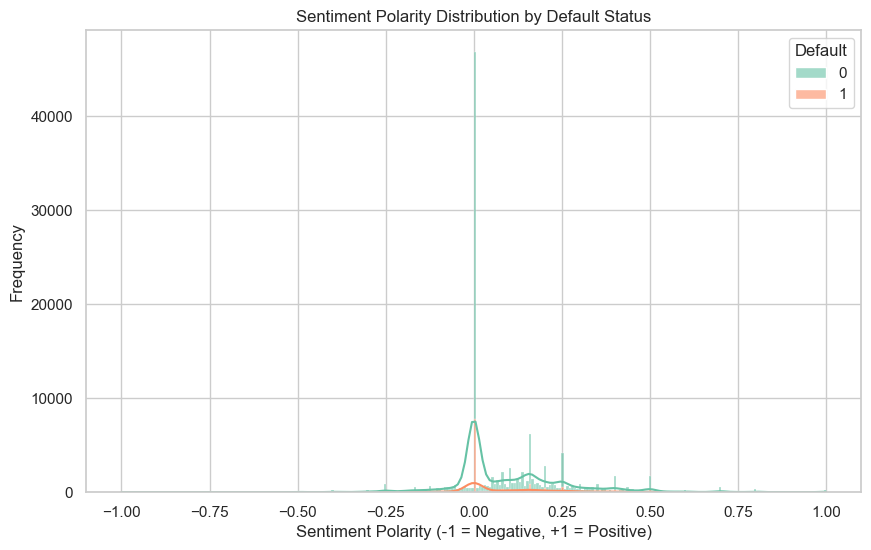

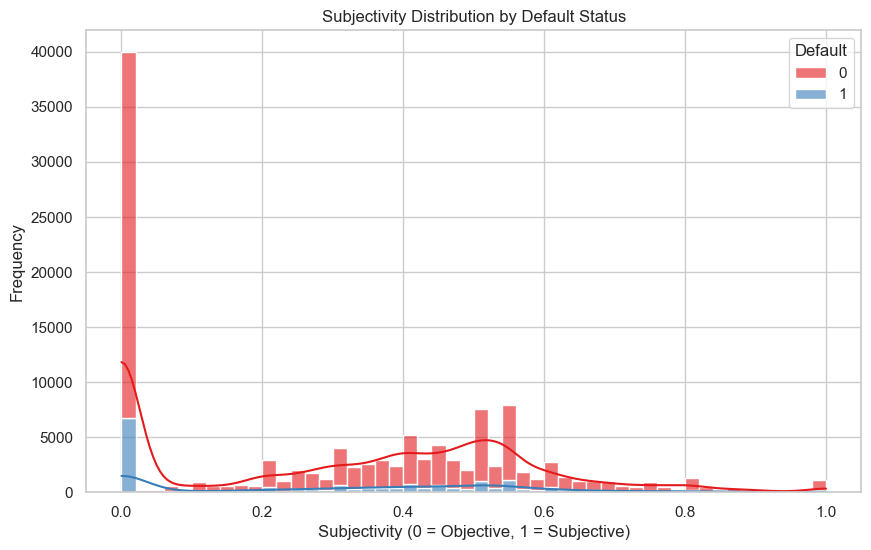

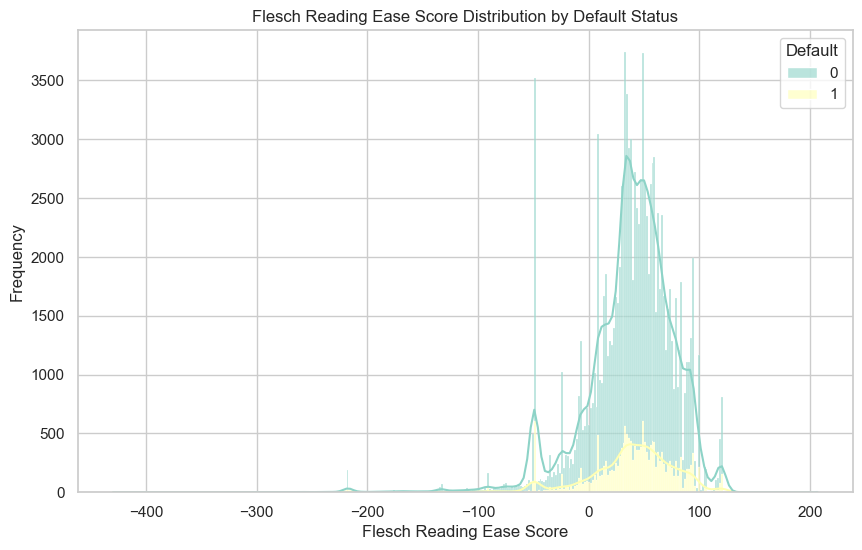

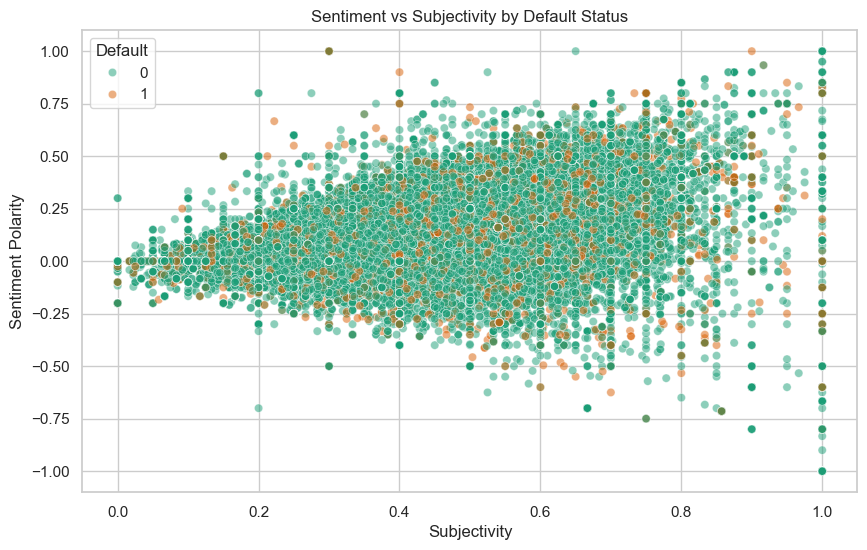

/var/folders/3l/49qb5gv15xl63y8w81pt12rm0000gn/T/ipykernel_24524/3717051.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Default', y='desc_flesch_score', data=loan_df, palette='pastel')


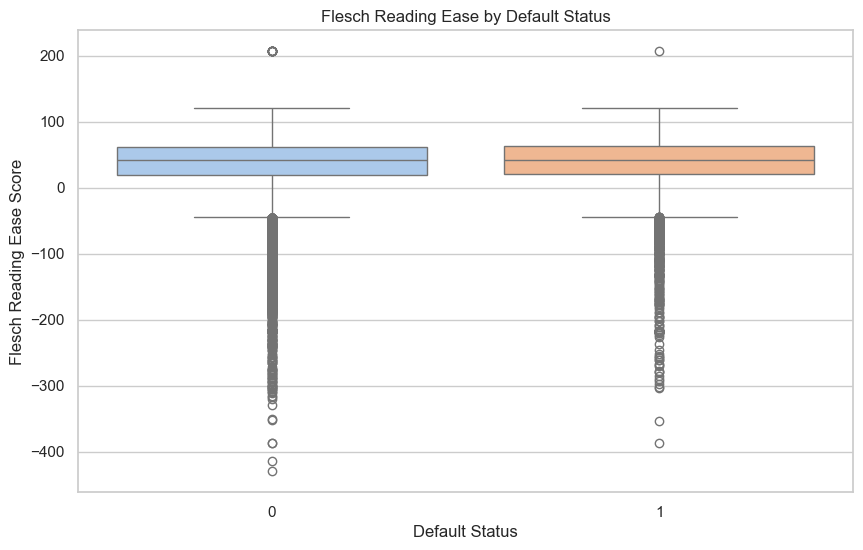

In [26]:
# Set style
sns.set(style="whitegrid")

# Sentiment Polarity Distribution by Default
plt.figure(figsize=(10, 6))
sns.histplot(data=loan_df, x='desc_sentiment', hue='Default', kde=True, palette='Set2', alpha=0.6, multiple='stack')
plt.title('Sentiment Polarity Distribution by Default Status')
plt.xlabel('Sentiment Polarity (-1 = Negative, +1 = Positive)')
plt.ylabel('Frequency')
plt.show()

# Subjectivity Distribution by Default
plt.figure(figsize=(10, 6))
sns.histplot(data=loan_df, x='desc_subjectivity', hue='Default', kde=True, palette='Set1', alpha=0.6, multiple='stack')
plt.title('Subjectivity Distribution by Default Status')
plt.xlabel('Subjectivity (0 = Objective, 1 = Subjective)')
plt.ylabel('Frequency')
plt.show()

# Flesch Reading Ease Score Distribution by Default
plt.figure(figsize=(10, 6))
sns.histplot(data=loan_df, x='desc_flesch_score', hue='Default', kde=True, palette='Set3', alpha=0.6, multiple='stack')
plt.title('Flesch Reading Ease Score Distribution by Default Status')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.show()

# Sentiment vs Subjectivity Scatter Plot by Default
plt.figure(figsize=(10, 6))
sns.scatterplot(x='desc_subjectivity', y='desc_sentiment', hue='Default', data=loan_df, alpha=0.5, palette='Dark2')
plt.title('Sentiment vs Subjectivity by Default Status')
plt.xlabel('Subjectivity')
plt.ylabel('Sentiment Polarity')
plt.legend(title='Default')
plt.show()

# Boxplot of Flesch Score by Default
plt.figure(figsize=(10, 6))
sns.boxplot(x='Default', y='desc_flesch_score', data=loan_df, palette='pastel')
plt.title('Flesch Reading Ease by Default Status')
plt.xlabel('Default Status')
plt.ylabel('Flesch Reading Ease Score')
plt.show()